## Кривоногов Н.В., Глубокое обучение в компьютерном зрении. Интерактивный курс, практическое задание № 6

Обучить сиамскую сеть для верификации лиц на датасете LFW

Библиотеки: [Python, Tensorflow]

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

##Загрузка датасета LFW

In [ ]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/0.1.0.incompleteVMHIYU/lfw-train.tfrecord*...:   0%|          | 0/1323…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild: A Database for Studying Face Recognition in
    Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path=PosixGPath('/tmp/tmptl1vfs0ptfds'),
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=uint8),
        'label': Text(shape=(), dtype=string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 20

Label: b'Tom_Amstutz'


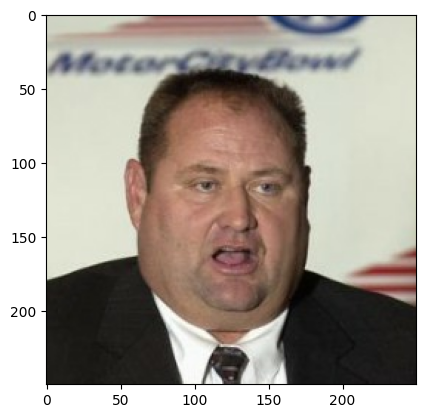

In [ ]:
for example in train_ds.take(1):  # Only take a single example
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

In [ ]:
for i,j in enumerate(train_ds):
    if i < 3:
        print(i, j)
    else:
        break

0 (<tf.Tensor: shape=(), dtype=string, numpy=b'Tom_Amstutz'>, <tf.Tensor: shape=(250, 250, 3), dtype=uint8, numpy=
array([[[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       ...,

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 24,  22,  23],
        [ 23,  21,  22],
        [ 23,  21,  22]],

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 27,  25,  26],
        [ 25,  23,  24],
        [ 24,  22,  23]],

       [[ 30,  29,  25],
        [ 29,  28,  24

##Создание модели CNN

In [ ]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

##Contrastive Loss

In [ ]:
MARGIN = 50.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

##Подготовка пайплайна данных

In [ ]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=10000, seed=5)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

##Визуализация датасета

In [ ]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

In [ ]:
labels

array([b'Mahmoud_Abbas', b'Harrison_Ford', b'Ruth_Stubbs',
       b'Stefano_Basalini'], dtype=object)

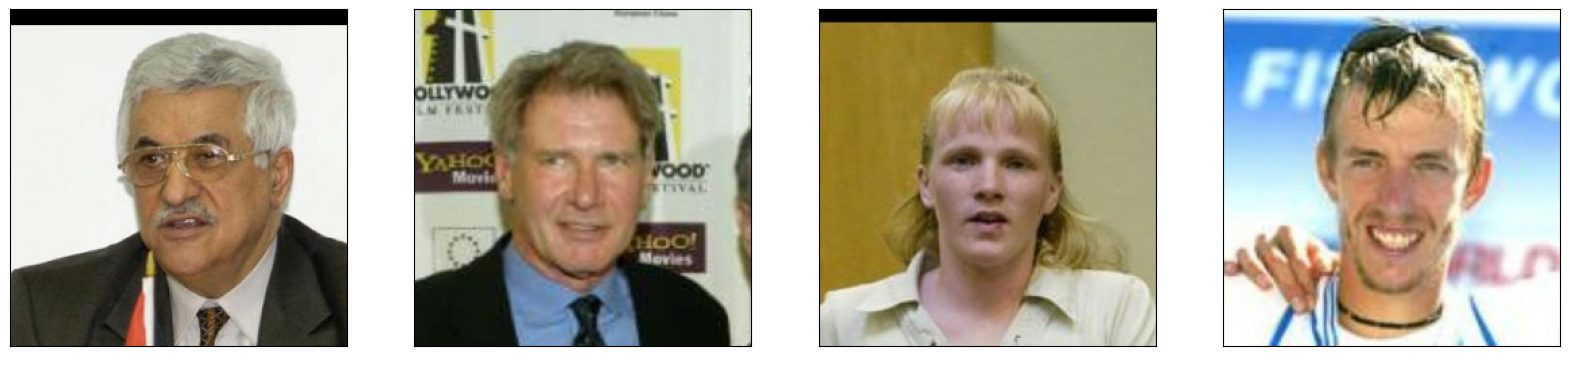

In [ ]:
fontdict = {'fontsize': '14', 'color': 'white'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

##Подготовка к обучению

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

##Обучение модели

In [ ]:
%%time

for iteration, (labels, images) in enumerate(train_ds):

    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)

    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

##Тестирование на новых данных

In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('George_W_Bush_1.jpeg')
img_a2 = load_and_prepare_image('George_W_Bush_2.jpg')
img_b = load_and_prepare_image('Jennifer_Garner.jpg')
img_c = load_and_prepare_image('Sally_Field.jpg')

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_c)
plt.show()

##Получение эмбеддингов для новых данных

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b, img_c), axis=0))

##Вычисление расстояний между эмбеддингами

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #George_W_Bush
emb2 = new_embs[1,:] #George_W_Bush
emb3 = new_embs[2,:] #Jennifer_Garner
emb4 = new_embs[3,:] #Sally_Field

print('George_W_Bush <-> George_W_Bush: ', diff(emb1, emb2))
print('George_W_Bush <-> Jennifer_Garner: ', diff(emb1, emb3))
print('George_W_Bush <-> Jennifer_Garner: ', diff(emb2, emb3))
print('George_W_Bush <-> Sally_Field: ', diff(emb1, emb4))
print('George_W_Bush <-> Sally_Field: ', diff(emb2, emb4))

Эмбеддинги фотографий Джоржа Буша оказались ближе, чем эмбеддинги фотографий разных людей.

#Сравним фотографии из обучающего датасета с фотографиями из интернета тех же людей: Mahmoud_Abbas, Harrison_Ford, Ruth_Stubbs, Stefano_Basalini.

##Получение эмбеддингов для картинок из трейна

In [ ]:
train_embs = model(images)

In [ ]:
train_emb1 = train_embs[0,:] #Mahmoud_Abbas
train_emb2 = train_embs[1,:] #Harrison_Ford
train_emb3 = train_embs[2,:] #Ruth_Stubbs
train_emb4 = train_embs[3,:] #Stefano_Basalini

##Загрзка фотографий из интернета

In [ ]:
img_a = load_and_prepare_image('Mahmoud_Abbas.jpg')
img_b = load_and_prepare_image('Harrison_Ford.jpg')
img_c = load_and_prepare_image('Stefano_Basalini.jpg')

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_c)
plt.show()

In [ ]:
embs = model(np.stack((img_a, img_b, img_c), axis=0))

emb1 = embs[0,:] #Mahmoud_Abbas
emb2 = embs[1,:] #Harrison_Ford
emb3 = embs[2,:] #Stefano_Basalini

In [ ]:
print('Mahmoud_Abbas <-> Mahmoud_Abbas: ', diff(emb1, train_emb1))
print('Harrison_Ford <-> Harrison_Ford: ', diff(emb2, train_emb2))
print('Stefano_Basalini <-> Stefano_Basalini: ', diff(emb3, train_emb3))

Здесь мы видим, что расстояния между эмбеддингами одних и тех же людей сравнимы с расстояниями между эмбеддингами разных людей в первом эксперименте. Больше всего на себя оказался похож Харрисон Форд.